출처: https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

Stacking은 앙상블의 변형. Stacking은 첫번째 단계에서 몇가지 기본 분류기로 예측을 한, 다음 두번째 단계에선 다른 모델을 사용하여 이전 첫번째 단계의 예측으로 최종 output을 예측한다.

In [1]:
# Load in our libraries
import re
import sklearn
import xgboost as xgb
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")
PassengerId = test["PassengerId"]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Feature Engineering

In [6]:
full_data = [train, test]

train["Name_length"] = train["Name"].apply(len)
test["Name_length"] =test["Name"].apply(len)

# Cabin 유무
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# SibSp와 Parch를 합쳐 FamilySize 칼럼 생성
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
# FamilySize로 부터 IsAlone 칼럼 생성
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"] == 1, "IsAlone"] = 1

# Embarked 칼럼의 Null 값을 다른 값으로 대체
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    
# Fare 칼럼의 Null 값을 다른 값으로 대체하고, 4개의 카테고리를 가진 CategoricalFare 생성
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
train["CategoricalFare"] = pd.qcut(train["Fare"], 4)

# CategoricalAge 생성
for dataset in full_data:
    age_avg = dataset["Age"].mean()
    age_std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    print(age_null_count)
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std,
                                             size=age_null_count)
    dataset.loc[dataset["Age"].isnull(), "Age"] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
train["CategoricalAge"] = pd.cut(train["Age"], 5)

# Mr, Miss와 같은 탑승객의 호칭을 추출하는 함수
def get_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return ""

# 탑승객의 호칭을 담은 Title 칼럼 생성
for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)
    
# 빈도수가 적은 데이터는 Rare로 바꾼다.
for dataset in full_data:
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
                                                "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    
for dataset in full_data:
    # Mapping Sex
    dataset["Sex"] = dataset["Sex"].map({"female": 0, "male": 1}).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)
    
    # Mapping Embarked
    dataset["Embarked"] = dataset["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)
    
    # Mapping Age
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4

177
86


In [7]:
# Feature Selection
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis=1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)

# Visualisations

In [8]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


## Pearson Correlation Heatmap

feature간 상관관계 확인

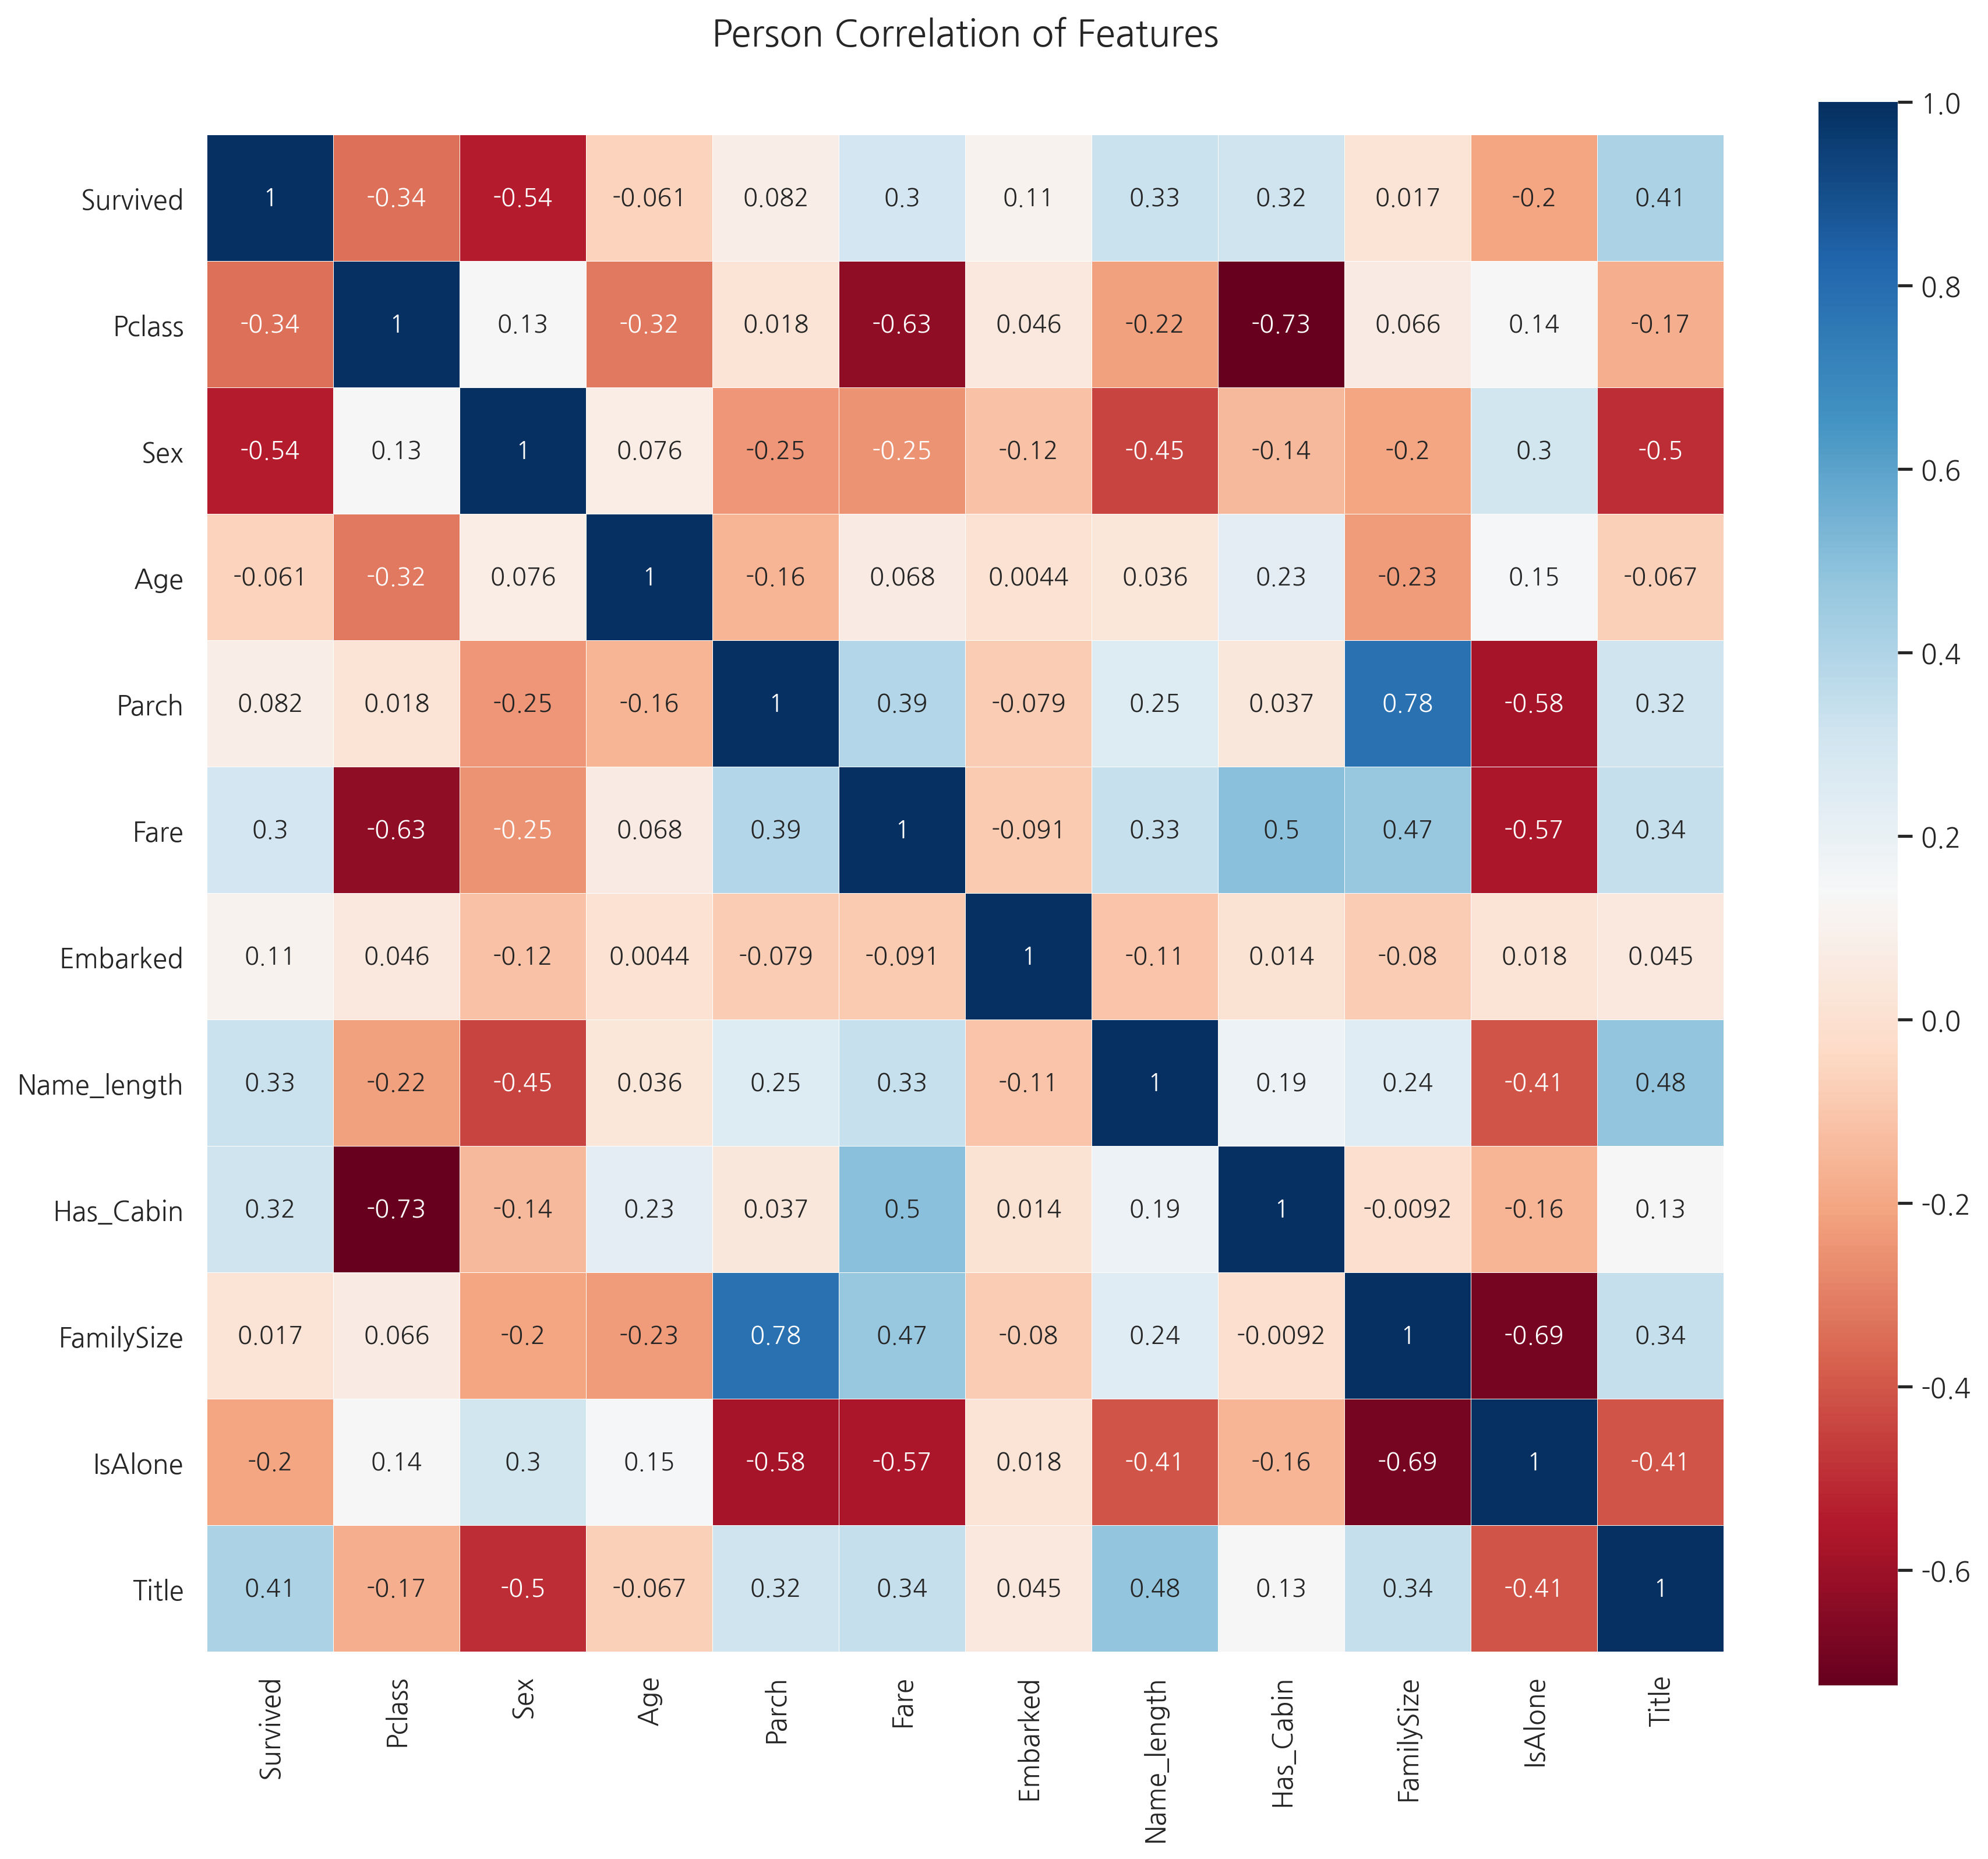

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Person Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor="white", annot=True)

FmilySize와 Parch를 제외하곤 매우 강한 상관관계를 가지는 feaure은 없어보입니다.

(두 feature는 원래 삭제하는 것이 좋으나 연습단계이기 때문에 그냥 넘어갑니다)

## Pairplots
두 개의 feature간의 분포를 확인하기 위해 pairplots를 생성합니다.

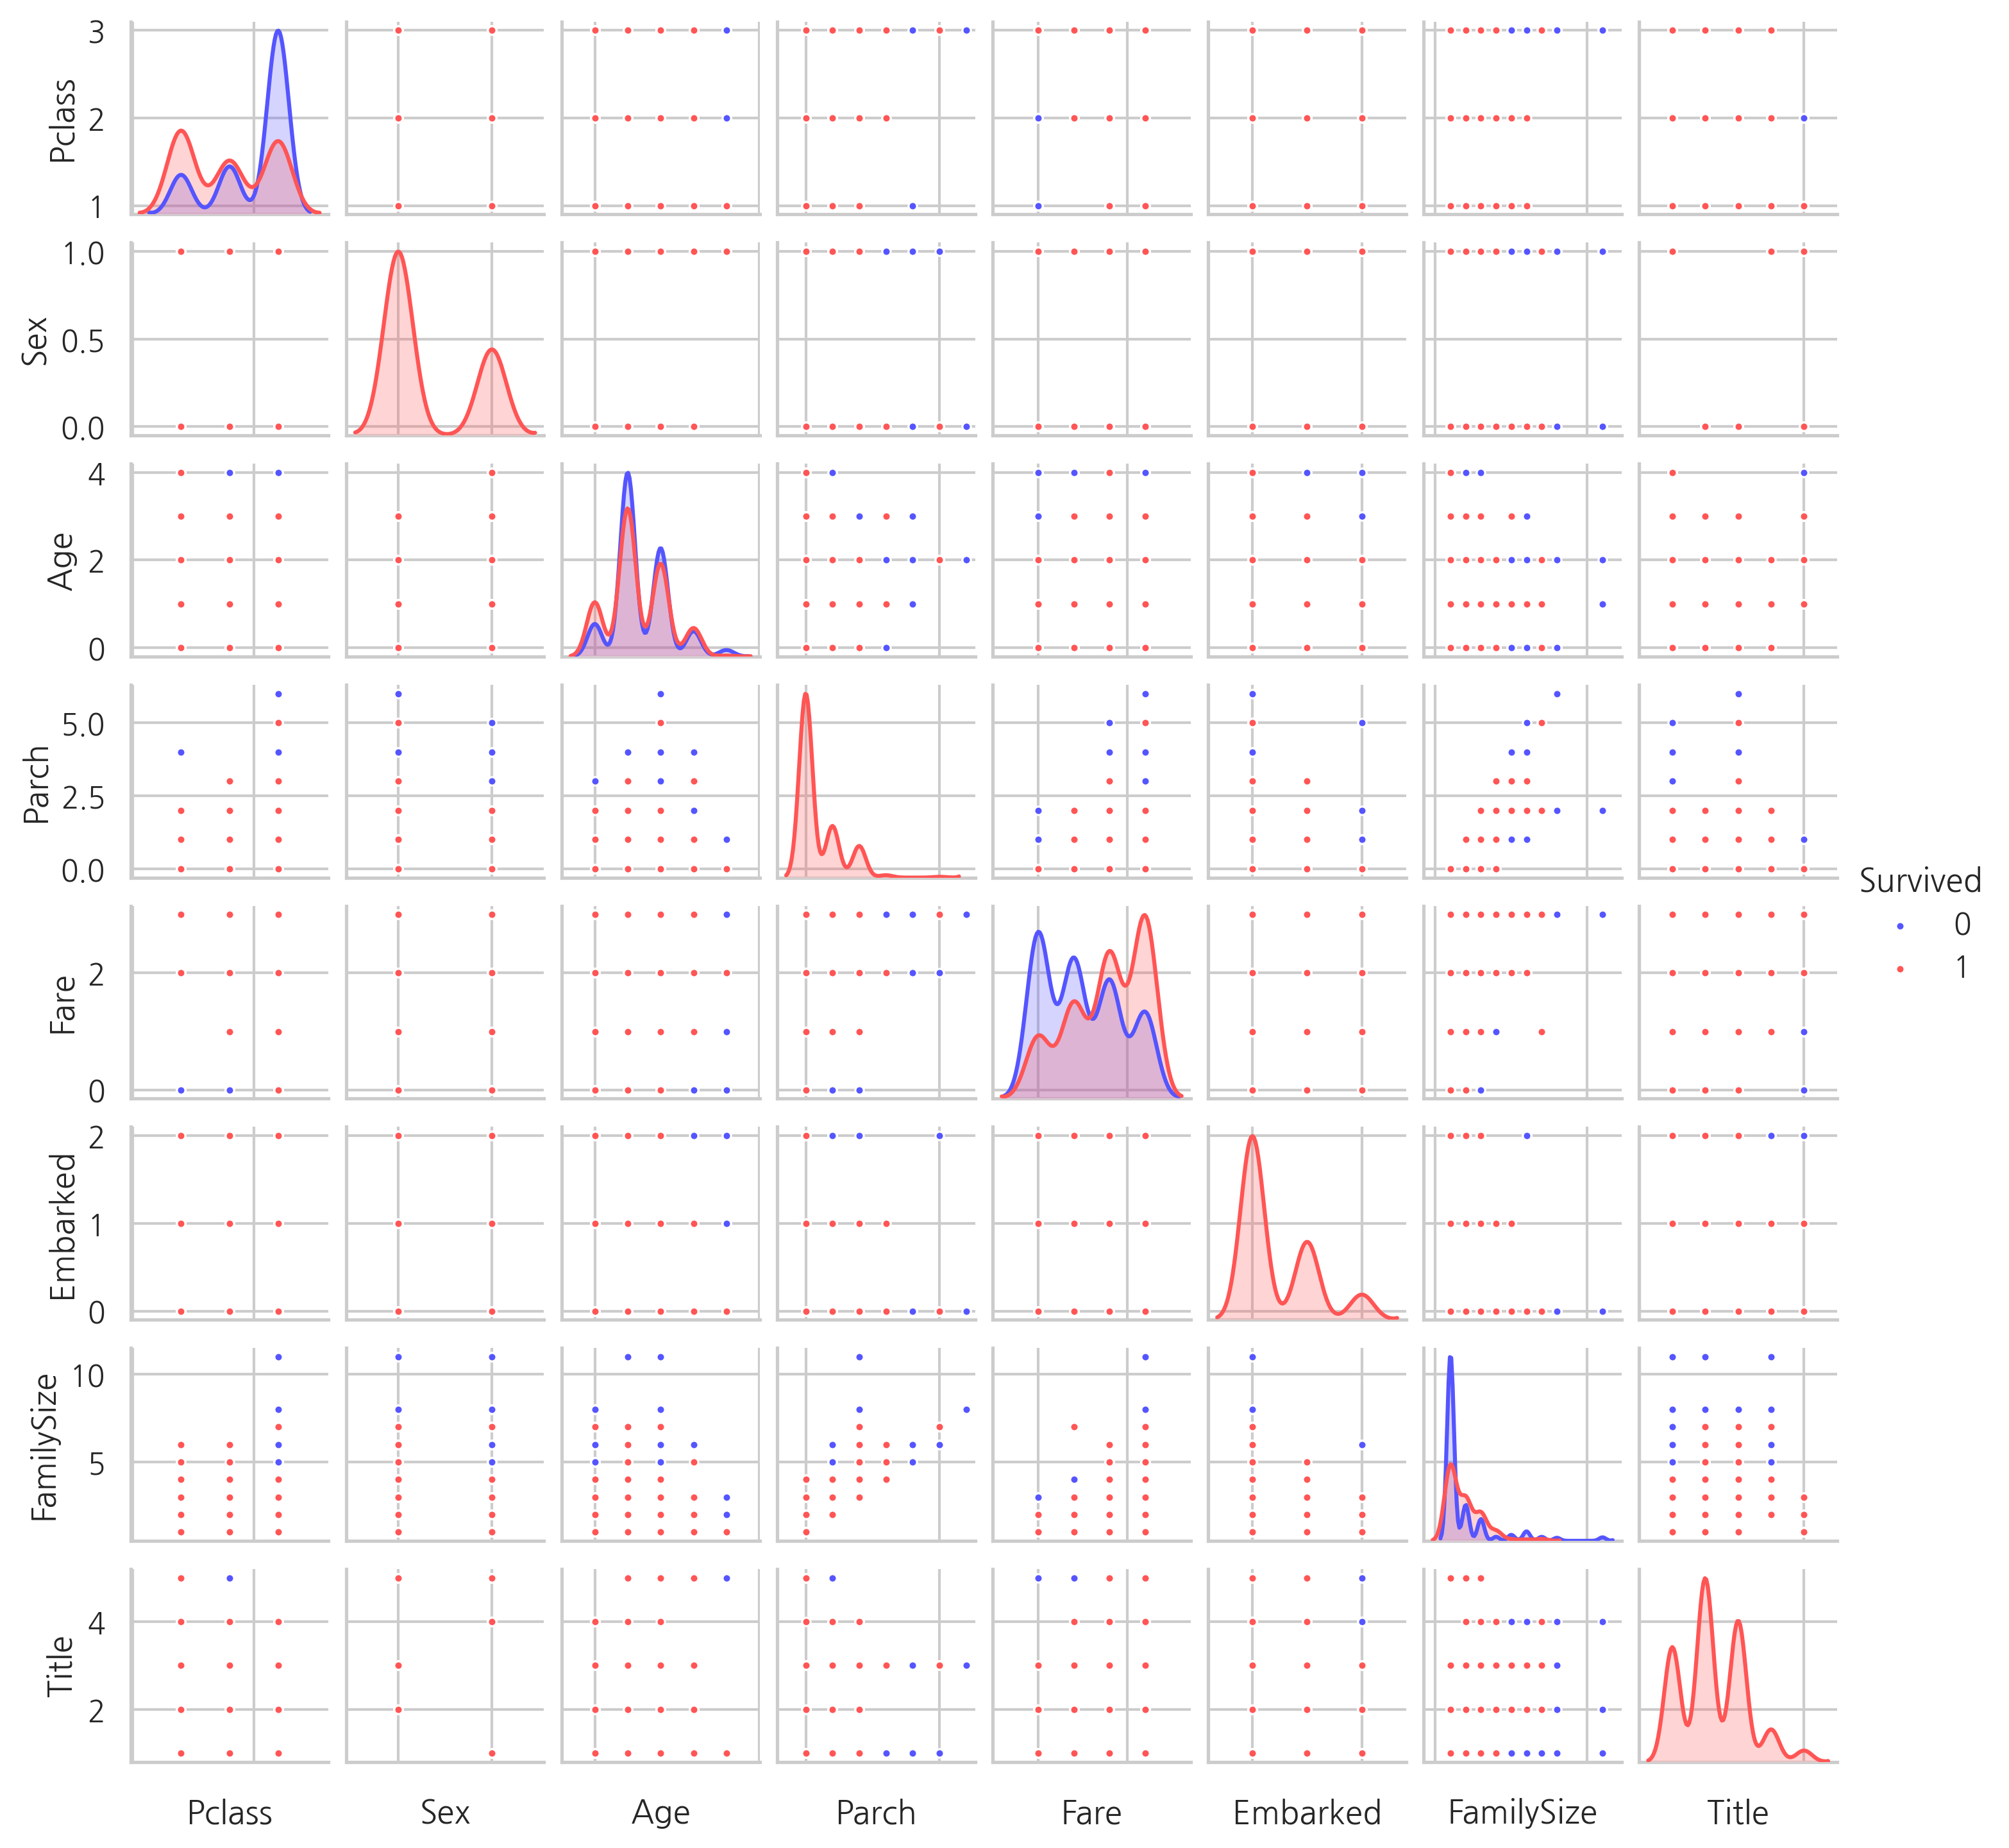

In [10]:
g = sns.pairplot(train[["Survived", "Pclass", "Sex", "Age", "Parch", "Fare",
                        "Embarked", "FamilySize", "Title"]], hue="Survived", 
                 palette="seismic", size=1.2, diag_kind="kde", diag_kws=dict(shade=True),
                 plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking models

## Helpers via Python Classes

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)
        return self.clf.fit(x, y).feature_importances_

## Out-of-Fold Predictions

* Out-of-Fold: K-Fold cross validation을 통해 얻어진 전체 예측 값



In [12]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) 

# Generating our Base First-Level Models

## Parameters

- n_jobs: 훈련 시 사용할 프로세스 숫자
- n_estimators: classification tree의 수
- max_depth: 트리의 최대 깊이 (너무 큰 숫자를 설정하면 overfitting이 될 수 있음)

In [13]:
# Random Forest parameters
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    "warm_start": True, # .fit을 실행할 때 이전의 weight를 기억하고 그대로 이어서 업데이트. ensemble 모델일때 사용
    "max_depth": 6,
    "min_samples_leaf": 2, # leaf node에 있어야 하는 최소 샘플 수,
    "max_features": "sqrt", # split을 할 때, 고려할 feature의 수가 sqrt(n_features), auto와 동일
    "verbose": 0
}

# Extra Trees Parameters
et_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    "max_depth": 8,
    "min_samples_leaf": 2,
    "verbose": 0
}

# AdaBoost parameters
ada_params = {
    "n_estimators": 500,
    "learning_rate": 0.75
}

# Gradient Boosting parameters
gb_params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_leaf": 2,
    "verbose": 0
}

# Support Vector Classifier parameters
svc_params = {
    "kernel": "linear",
    "C": 0.025
}

In [14]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## Creating NumPy arrays out of our train and test sets

In [15]:
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis=1)
x_train = train.values
x_test = test.values

### Output of the First level Predictions

In [16]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)

### Feature importances generated from the different classifier

In [17]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.11297712 0.21992303 0.03739706 0.0215505  0.05321412 0.02994163
 0.12057478 0.06019532 0.07586657 0.01170545 0.25665442]
[0.12058936 0.37886445 0.02876845 0.01672613 0.05613948 0.02785238
 0.04624065 0.08386114 0.04514501 0.02145094 0.17436201]
[0.03  0.008 0.014 0.064 0.04  0.01  0.708 0.014 0.046 0.004 0.062]
[0.08640323 0.01227822 0.05044546 0.01239049 0.05315193 0.02556997
 0.17221705 0.03845785 0.11117741 0.00637753 0.43153085]


In [18]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols, 
                                  'Random Forest feature importances': rf_feature, 
                                  'Extra Trees  feature importances': et_feature, 
                                  'AdaBoost feature importances': ada_feature, 
                                  'Gradient Boost feature importances': gb_feature
                                 })

In [19]:
feature_dataframe.columns

Index(['features', 'Random Forest feature importances',
       'Extra Trees  feature importances', 'AdaBoost feature importances',
       'Gradient Boost feature importances'],
      dtype='object')

### Interactive feature importances via Plotly scatterplots

In [20]:
# Scatter plot
for col in feature_dataframe.columns:
    if col == "features":
        continue
        
    trace = go.Scatter(
        y=feature_dataframe[col].values,
        x=feature_dataframe["features"].values,
        mode="markers",
        marker=dict(
            sizemode="diameter",
            sizeref=1,
            size=25,
            color=feature_dataframe[col].values,
            colorscale="Portland",
            showscale=True
        ),
        text = feature_dataframe["features"].values
    )
    data = [trace]

    layout = go.Layout(
        autosize=True,
        title=col,
        hovermode="closest",
        yaxis=dict(
            title="Feature Importance",
            ticklen=5,
            gridwidth=2
        ),
        showlegend=False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename="scatter2010")

모든 feature importances의 평균을 계산해서 새로운 칼럼에 저장을 합니다.

In [21]:
feature_dataframe["mean"] = feature_dataframe.mean(axis=1)
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.112977,0.120589,0.030,0.086403,0.087492
1,Sex,0.219923,0.378864,0.008,0.012278,0.154766
2,Age,0.037397,0.028768,0.014,0.050445,0.032653
3,Parch,0.021551,0.016726,0.064,0.012390,0.028667
4,Fare,0.053214,0.056139,0.040,0.053152,0.050626


### Plotly Barplot of Average Feature Importances

In [22]:
y = feature_dataframe["mean"].values
x = feature_dataframe["features"].values
data = [go.Bar(
    x=x,
    y=y,
    width=0.5,
    marker=dict(
        color=feature_dataframe["mean"].values,
        colorscale="Portland",
        showscale=True,
        reversescale=False
    ),
    opacity=0.6
)]

layout = go.Layout(
    autosize=True,
    title="Barplots of Mean Feature Importance",
    hovermode="closest",
    yaxis=dict(
        title="Feature Importance",
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="bar-direct-labels")

# Second-Level Predictions from the First-level Output

## First-level output as new features

In [23]:
base_predictions_train = pd.DataFrame({
    "RandomForest": rf_oof_train.ravel(),
    "ExtraTrees": et_oof_train.ravel(),
    "AdaBoost": ada_oof_train.ravel(),
    "GradientBoost": gb_oof_train.ravel()
})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


## Correlation Heatmap of the Second Level Training set

In [24]:
data = [go.Heatmap(
    z=base_predictions_train.astype(float).corr().values,
    x=base_predictions_train.columns.values,
    y=base_predictions_train.columns.values,
    colorscale="Viridis",
    showscale=True,
    reversescale=True
)]
py.iplot(data, filename="labelled-heatmap")

In [25]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

## Second level learning model via XGBoost

In [26]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2, # 값이 클수록 모델은 보수적
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    nthread=-1,
    scale_pos_weight=1 # imbalance data에 사용, sum(negative instances) / sum(positive instances)
).fit(x_train, y_train)

predictions = gbm.predict(x_test)

[15:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Producing the Submission file

In [27]:
StackingSubmission = pd.DataFrame({
    "PassengerId": PassengerId,
    "Survived": predictions
})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

------------
# End